# SI618 Project
### Analyzing the Impact of Various Factors on B&B Visitor's Reviews 
#### — A study based on Airbnb datasets

Team members: Qian Dong (dqq) section 001; Yujun Zhang (yukiz) section 001; Yinuo Wei (seesaway) section 001


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Cleaning and manipulation
1. Primary dataset description

In [74]:
ab=pd.read_csv('data/AB_NYC_2019.csv')

In [75]:
ab.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [76]:
ab.shape

(48895, 16)

In [77]:
ab.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [78]:
ab.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


id                                   Axes(0.125,0.653529;0.168478x0.226471)
host_id                           Axes(0.327174,0.653529;0.168478x0.226471)
latitude                          Axes(0.529348,0.653529;0.168478x0.226471)
longitude                         Axes(0.731522,0.653529;0.168478x0.226471)
price                                Axes(0.125,0.381765;0.168478x0.226471)
minimum_nights                    Axes(0.327174,0.381765;0.168478x0.226471)
number_of_reviews                 Axes(0.529348,0.381765;0.168478x0.226471)
reviews_per_month                 Axes(0.731522,0.381765;0.168478x0.226471)
calculated_host_listings_count           Axes(0.125,0.11;0.168478x0.226471)
availability_365                      Axes(0.327174,0.11;0.168478x0.226471)
dtype: object

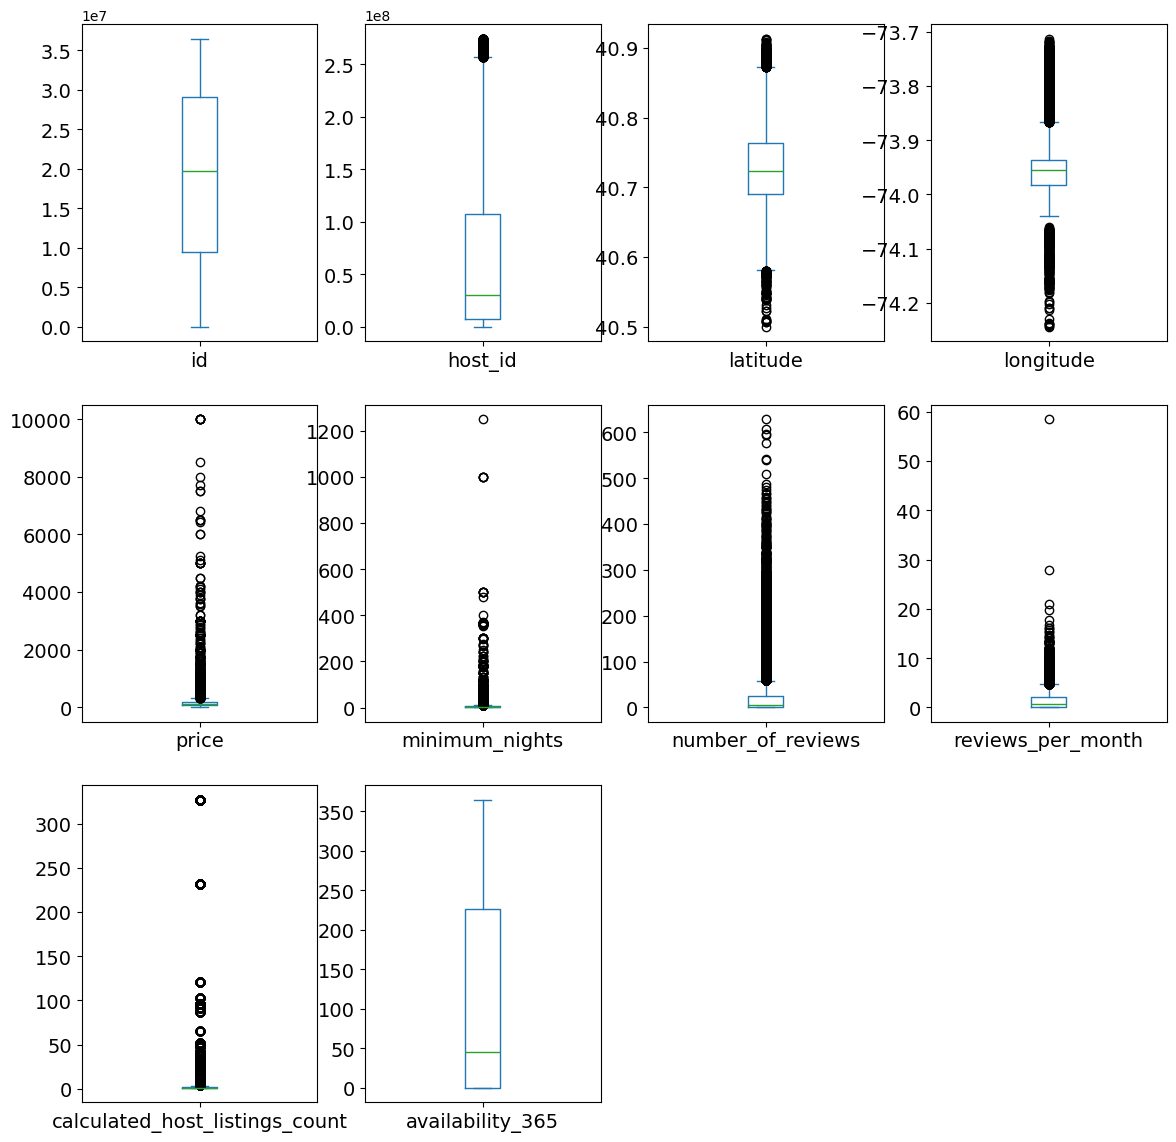

In [79]:
ab.select_dtypes(exclude=['object'])\
    .plot(kind='box', subplots=True, layout=(3,4), figsize=(14,14), fontsize=14)

In [80]:
ab.select_dtypes(exclude=['object']).isna().sum()

id                                    0
host_id                               0
latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Only review_per_month has missing values

In [81]:
ab['reviews_per_month'].min()

0.01

we can infer that the missing value should be 0.

In [82]:
#replace missing with mode
ab['reviews_per_month'].fillna(0, inplace=True)

updated graph:

<Axes: >

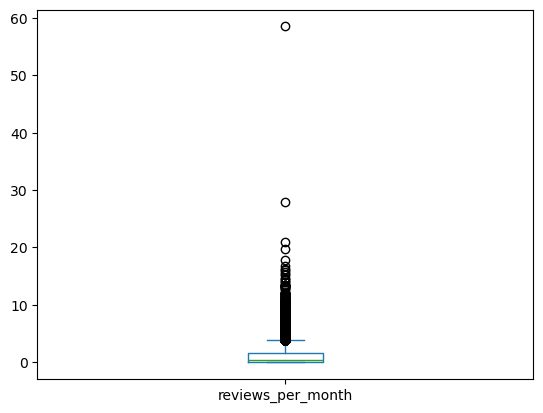

In [94]:
ab['reviews_per_month'].plot(kind='box')

<Axes: >

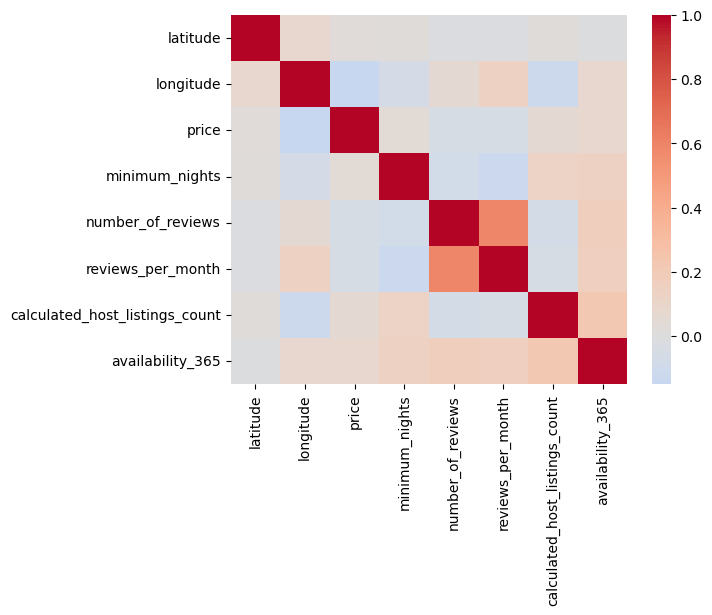

In [83]:
sns.heatmap(ab.select_dtypes(exclude=['object']).drop(['id', 'host_id'], axis=1)
            .corr(), cmap='coolwarm', center=0)

In [84]:
ab.select_dtypes(include=['object']).head()

,name,host_name,neighbourhood_group,neighbourhood,room_type,last_review
0,Clean & quiet apt home by the park,John,Brooklyn,Kensington,Private room,2018-10-19
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,Entire home/apt,2019-05-21
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,Private room,NaN
3,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,2019-07-05
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,Entire home/apt,2018-11-19


<Axes: xlabel='neighbourhood_group'>

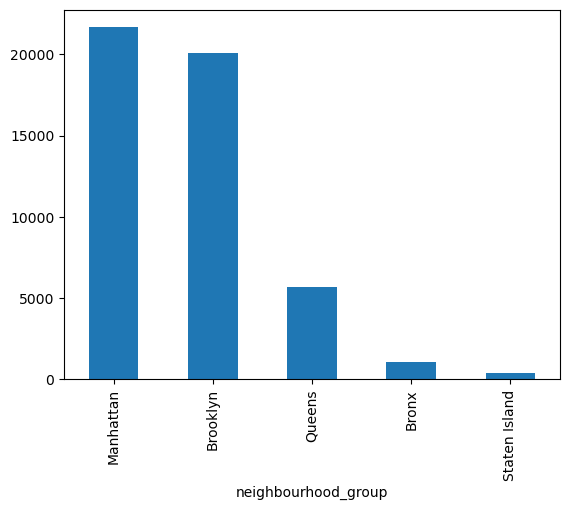

In [85]:
ab['neighbourhood_group'].value_counts().plot(kind='bar')

In [86]:
ab['neighbourhood'].nunique()

221

In [87]:
ab['neighbourhood'].value_counts().head(10)

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
Hell's Kitchen        1958
East Village          1853
Upper East Side       1798
Crown Heights         1564
Midtown               1545
Name: count, dtype: int64

<Axes: xlabel='room_type'>

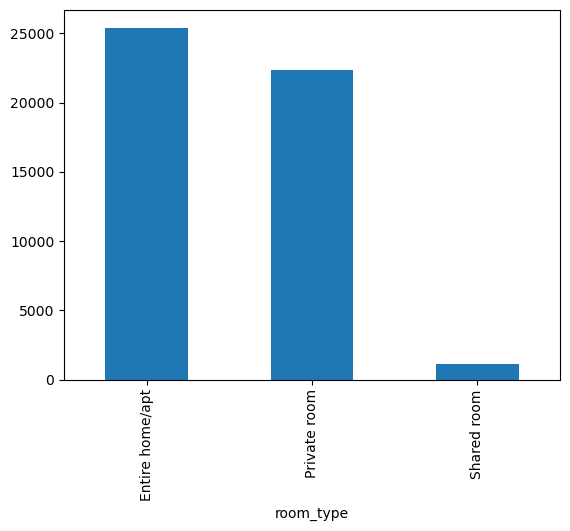

In [88]:
ab['room_type'].value_counts().plot(kind='bar')

<Axes: xlabel='last_review'>

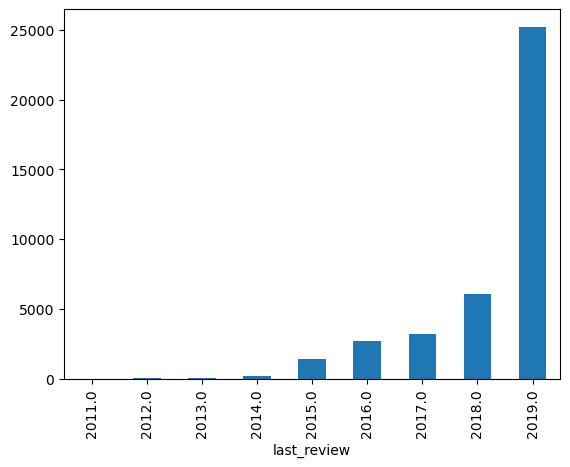

In [89]:
ab['last_review']=pd.to_datetime(ab['last_review'])
ab['last_review'].dt.year.value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='last_review'>

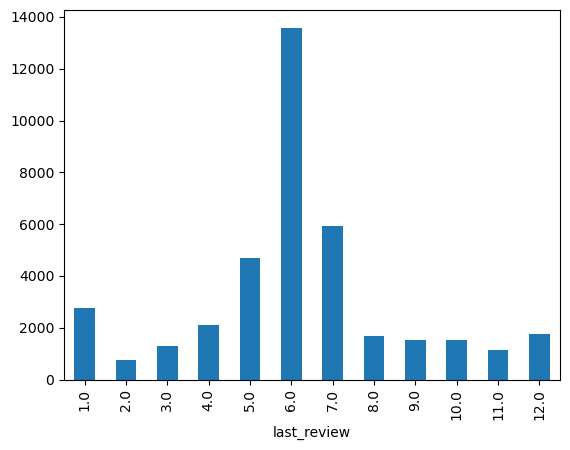

In [90]:
ab['last_review'].dt.month.value_counts().sort_index().plot(kind='bar')

In [91]:
# last and first review
ab['last_review'].max(), ab['last_review'].min()

(Timestamp('2019-07-08 00:00:00'), Timestamp('2011-03-28 00:00:00'))

In [92]:
ab['last_review'].value_counts().head(10)

last_review
2019-06-23    1413
2019-07-01    1359
2019-06-30    1341
2019-06-24     875
2019-07-07     718
2019-07-02     658
2019-06-22     655
2019-06-16     601
2019-07-05     580
2019-07-06     565
Name: count, dtype: int64

In [70]:
ab.select_dtypes(exclude=['number']).isna().sum()

name                      16
host_name                 21
neighbourhood_group        0
neighbourhood              0
room_type                  0
last_review            10052
dtype: int64

Missing names are not meaningful to fill. Only missing last_review can be filled. The missing value is corresponding to the missing value of review_per_month. So we should keep the missing values as null because it has the meaning of having no review.

In [104]:
ab[ab['last_review'].isna()][['number_of_reviews', 'last_review', 'reviews_per_month']].sample(5)

,number_of_reviews,last_review,reviews_per_month
48333,0,NaT,0.0
48165,0,NaT,0.0
29101,0,NaT,0.0
24973,0,NaT,0.0
11599,0,NaT,0.0


In [100]:
ab[ab['last_review'].isna()][['number_of_reviews', 'last_review', 'reviews_per_month']].nunique()

number_of_reviews    1
last_review          0
reviews_per_month    1
dtype: int64

It turns out that missing values of review related data are all because reviews do not exit.

2. Secondary dataset description

In [105]:
reviews=pd.read_csv('data/AB_reviews_NYC.csv')

In [106]:
reviews.head()

,listing_id,url,review_posted_date,review
0,2595,https://www.airbnb.com/rooms/2595,November 2019,"Great location, convenient to everything. Very..."
1,2595,https://www.airbnb.com/rooms/2595,May 2019,Place was so cute and comfy! Host was great an...
2,2595,https://www.airbnb.com/rooms/2595,May 2019,10 / 10 would stay again
3,2595,https://www.airbnb.com/rooms/2595,January 2019,The apartment met expectations to how it was i...
4,2595,https://www.airbnb.com/rooms/2595,December 2018,Great space in a fun old building in NYC. Love...
